# AI Kit

This jupyter notebook series constitutes a miscellaneous collection of code-snippeds for generic tasks in ML/DL-projects. The purpose is to speed up and ease model development by providing content for copying / pasting / and further customization. Each section constitutes a separat jupyter notebook.

#### A - BASICS
1. **Data Preprocessing** - Imputation, Normalization
2. **Oulier Detection** - Univariate Z-Score, Isolation Forest, Elliptic Envelope, DBSCAN
3. **Dimensionality Reduction** - PCA, tSNE

#### B - MACHINE LEARNING (SkLearn)
1. **Model Selection** - Benchmarking Algorithms with default Hyperparameters
2. **Hyperparamter Tuning** - Random Search, Learning Curves

#### C - DEEP LEARNING (Keras)
1. **Neural Nets** - Keras Sequential Model
2. **CNNs** - from Scratch, Transferlearning
3. **RNNs** - from Scratch, Transferlearning
4. **Complex Model Graphs** - Functional Keras API

## Notebook A2 - Oulier Detection

* [**Preprocess Data**](#pd)
* [**Univariate z-Score**](#zs)
* [**Isolation Forest**](#if)
* [**Elliptic Envelope**](#ee)
* [**DBSCAN**](#ds)

Nice notebook on outlier detection: https://www.kaggle.com/kevinarvai/outlier-detection-practice-uni-multivariate

### Preprocess Data<a name="pd"></a>

For details refer to previous notebook 1_DataPreprocessing

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

titanic = sns.load_dataset('titanic')

# Directly remove features 'alive' and 'embark_town' which duplicate 'survived' and 'embark'
titanic = titanic.drop(columns=['embark_town', 'alive'])

# Drop feature 'deck' with too many NAs
titanic = titanic.drop(columns='deck')

# Impute age with average
titanic.loc[titanic.age.isna(), 'age'] = titanic.age.mean()

# Impute embarked with most frequent
titanic.embarked.value_counts()

# One hot encode categorical features
titanic_categorical = titanic.loc[:, (titanic.dtypes=='object') | (titanic.dtypes=='category')]
titanic = titanic.drop(columns=titanic_categorical.columns)
titanic = titanic.join(pd.get_dummies(titanic_categorical, drop_first=True))

# Convert everything to float32
titanic = titanic.astype('float32')
titanic.head()

# Lognormalize 'price'
titanic['fare'] = np.log(titanic.fare+1)

# Normalize non-categorical features
titanic.loc[:, 'pclass':'fare'] = (titanic.loc[:, 'pclass':'fare'] - titanic.loc[:, 'pclass':'fare'].mean()) /\
                                                                     titanic.loc[:, 'pclass':'fare'].std()

### Univariate z-Score<a name="zs"></a>

Flag observations as outliers that are z standard deviation units away from average.

C:\Users\g.spiegel\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


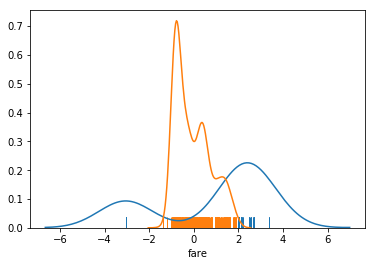

In [91]:
def z_score_outlier(series, z_score):
    std = series.std()
    mean = series.mean()
    return [np.abs(s-mean) > z_score*std for s in series]

ax = sns.distplot(titanic[z_score_outlier(titanic.fare, 2)].fare, rug=True, hist=False)
ax = sns.distplot(titanic[[not i for i in z_score_outlier(titanic.fare, 2)]].fare, rug=True, hist=False)

### Isolation Forest<a name="if"></a>

This algorithm flags observations as outliers if it only needs very few decision boundaries (tree depth) for isolating them: http://www.extended-cognition.com/2018/11/15/multivariate-outlier-detection-with-isolation-forests/

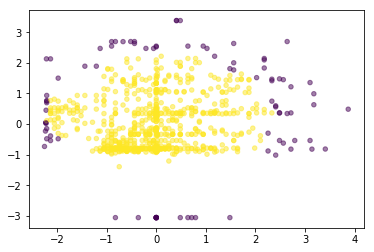

In [96]:
from sklearn.ensemble import IsolationForest

# For graphical purposes restrict on 'age' and 'fare'
titanic_af = titanic.loc[:, ['age', 'fare']]

# outlier-ratio is specified via 'contamination'
# multivariate case corresponds to 'max_features' = number of features
# univariate case corresponds to 'max_features' = 1
iforest = IsolationForest(n_estimators=100, contamination=.1, max_features=titanic_af.shape[1], behaviour='new')
iforest.fit(titanic_af)

plt.scatter(titanic_af['age'], titanic_af['fare'], c=iforest.predict(titanic_af), s=20, alpha=.5)

### Elliptic Envelope<a name="ee"></a>

This algorithm fits an n-dimenaional elliptic shape around data and flags observations outside this shape as outliers.

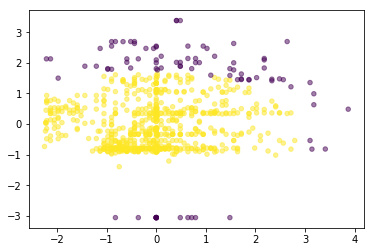

In [94]:
from sklearn.covariance import EllipticEnvelope

eenv = EllipticEnvelope(contamination=0.1)
eenv.fit(titanic_af)

plt.scatter(titanic_af['age'], titanic_af['fare'], c=eenv.predict(titanic_af), s=20, alpha=.5)

### DBSCAN<a name="ds"></a>

This algorithm clusters observations with distance < 'eps' and minimum cluster members > 'min_samples'. The residual is put into one outlier-cluster.

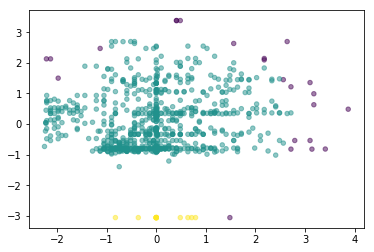

In [82]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN(eps=0.5, min_samples=10)
dbs.fit(titanic_af)

plt.scatter(titanic_af['age'], titanic_af['fare'], c=dbs.labels_, s=20, alpha=.5)